Homework 3

In [4]:
# Import Packages
from pyspark import SparkConf, SparkContext
from pyspark.ml.linalg import Vectors
import random
import time

In [5]:
random.seed(42)

In [6]:
def readVectorsSeq(filename):
    file = open(filename, 'r')
    vector_list = []
    for row in file.readlines():
        vector_list.append(Vectors.dense([float(num_str) for num_str in row.split()]))
    return vector_list

In [7]:
vector_list = readVectorsSeq('test-datasets/prova.txt')

# Print Info of the Dataset
print('INFO OF THE DATASET:')
print('- Number of points:', len(vector_list))
print('- Dimensionality of a Point:', len(vector_list[0]))

INFO OF THE DATASET:
- Number of points: 11
- Dimensionality of a Point: 50


# k-Center 

Basically the same of Guglielmo's because his version was better and without the bottleneck exploited by mine. In order to speed up performances I deleted few vars that was useful just for the sake of debugging.

In [8]:
def kcenter(P, k):
    P_minus_S = [p for p in P]
    idx_rnd = random.randint(0, len(P)-1)
    S = [P[idx_rnd]]
    dist_near_center = [Vectors.squared_distance(P[i], S[0]) for i in range(len(P))]

    for i in range(k-1):    
        new_center_idx = max(enumerate(dist_near_center), key=lambda x: x[1])[0] # argmax operation
        S.append(P[new_center_idx])

        for j in range(len(P)):
            if j != new_center_idx:
                dist = Vectors.squared_distance(P[j], S[-1])
                if dist < dist_near_center[j]:
                    dist_near_center[j] = dist
            else:
                dist_near_center[j] = 0
    return S

# Elapsed time evaluation

In [9]:
vector_list = readVectorsSeq('test-datasets/vecs-50-10000.txt')
k = 10 

t0 = time.time()
C = kcenter(vector_list,k)
t1 = time.time()

print('Number of points:', len(vector_list))
print('Elapsed Time first set :', t1-t0, 's')

vector_list = readVectorsSeq('test-datasets/vecs-50-50000.txt')

t0 = time.time()
C = kcenter(vector_list,k)
t1 = time.time()

print('Number of points:', len(vector_list))
print('Elapsed Time first set :', t1-t0, 's')

vector_list = readVectorsSeq('test-datasets/vecs-50-100000.txt')

t0 = time.time()
C = kcenter(vector_list,k)
t1 = time.time()

print('Number of points:', len(vector_list))
print('Elapsed Time first set :', t1-t0, 's')

vector_list = readVectorsSeq('test-datasets/vecs-50-500000.txt')

t0 = time.time()
C = kcenter(vector_list,k)
t1 = time.time()

print('Number of points:', len(vector_list))
print('Elapsed Time first set :', t1-t0, 's')

Number of points: 9960
Elapsed Time first set : 1.0240862369537354 s
Number of points: 50047
Elapsed Time first set : 5.158405780792236 s
Number of points: 99670
Elapsed Time first set : 10.598963975906372 s


FileNotFoundError: [Errno 2] No such file or directory: 'test-datasets/vecs-50-500000.txt'

# k-means++

In [10]:
import numpy as np

def kmeansPP(P, k):
    idx_rnd = random.randint(0, len(P)-1)
    S = [P[idx_rnd]]
    dist_near_center = [Vectors.squared_distance(P[i], S[0]) for i in range(len(P))]

    for i in range(k-1):
        
        weights = dist_near_center/np.sum(dist_near_center)
        idx = np.random.choice(range(len(P)),p=weights)
        #print(np.where(np.array(dist_near_center) == 0)[0])
        S.append(P[idx])

        for j in range(len(P)):
            if j != idx:
                dist = Vectors.squared_distance(P[j], S[-1])
                if dist < dist_near_center[j]:
                    dist_near_center[j] = dist
            else:
                dist_near_center[j] = 0 # this assures that in dist_near_center we consider just distances of P minus S
    return S 

In [11]:
def kmeansObj(P, C):
    dist_near_center = [Vectors.squared_distance(P[i], C[0]) for i in range(len(P))]
    for i in range(1,k):
        for j in range(len(P)):
            dist = Vectors.squared_distance(P[j], C[i])
            if dist < dist_near_center[j]:
                dist_near_center[j] = dist
    return np.mean(dist_near_center) 

In [12]:
P = readVectorsSeq('test-datasets/vecs-50-10000.txt')
k = 10 

C = kmeansPP(P,10)
obj = kmeansObj(P,C)
print(obj)      

3.589493695029776


In [13]:
k1 = 100
k = 5

X = kcenter(P,k1)
C = kmeansPP(X,k)
print(kmeansObj(P,C))

13.93936113134447


Fit of the Time Complexity:
Time = 4.661563974039325e-05 * |P| + 0.00908158555322753 [s]


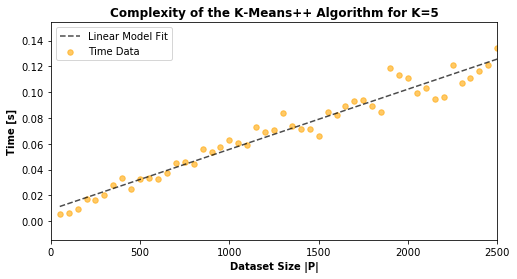

Fit of the Time Complexity:
Time = 0.001234358756625209 * K + -8.73600706762334e-05 [s]


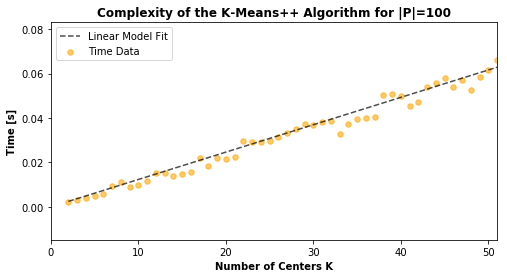

In [14]:
# Create the Datasets
n_datasets = 50
datasets = []
for n in range(n_datasets):
    vector_list = []
    np.random.seed(seed=n)
    n_points = 50*(n+1)
    for i in range(n_points):
        vector_list.append(Vectors.dense(np.random.rand(2)))
    datasets.append(vector_list)

times = []
datasets_centers = []
for n in range(n_datasets):
    P = [p for p in datasets[n]]
    t1 = time.time()
    centers = kmeansPP(P, 5)
    t2 = time.time()
    datasets_centers.append(centers)
    times.append(t2-t1)

# Get the Linear Regression Model for the Time
y = np.array(times).reshape(n_datasets, 1)
X = np.zeros((n_datasets, 2))
X[:, 0] = np.ones((n_datasets,))
X[:, 1] = np.arange(1, n_datasets+1)*n_datasets
beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
x = np.array([(i+1)*50 for i in range(n_datasets)])
linear_model = x*beta[1] + beta[0]

print('Fit of the Time Complexity:')
print('Time =', beta[1,0],'* |P| +', beta[0,0], '[s]')

import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(8, 4))
plt.title('Complexity of the K-Means++ Algorithm for K=5', fontweight='bold')
plt.scatter([(i+1)*50 for i in range(n_datasets)], times, alpha=0.6, c='orange', label='Time Data', s=30)
plt.plot(x, linear_model, c='k', lw=1.5, alpha=0.7, ls='--', label='Linear Model Fit')
plt.xlabel('Dataset Size |P|', fontweight='bold')
plt.ylabel('Time [s]', fontweight='bold')
plt.xlim(0, n_datasets*n_datasets)
plt.legend(loc=2, prop={'size':10})
plt.show()

# Create the Datasets
n_datasets = 50
datasets = []
for n in range(n_datasets):
    vector_list = []
    np.random.seed(seed=n)
    n_points = 100
    for i in range(n_points):
        vector_list.append(Vectors.dense(np.random.rand(2)))
    datasets.append(vector_list)

times = []
datasets_centers = []
for n in range(n_datasets):
    P = [p for p in datasets[n]]
    t1 = time.time()
    centers = kmeansPP(P, 2+n)
    t2 = time.time()
    datasets_centers.append(centers)
    times.append(t2-t1)

# Get the Linear Regression Model for the Time
y = np.array(times).reshape(n_datasets, 1)
X = np.zeros((n_datasets, 2))
X[:, 0] = np.ones((n_datasets,))
X[:, 1] = np.arange(1, n_datasets+1)
beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
x = np.array([2+i for i in range(n_datasets)])
linear_model = x*beta[1] + beta[0]

print('Fit of the Time Complexity:')
print('Time =', beta[1,0],'* K +', beta[0,0], '[s]')


# Plot
plt.figure(figsize=(8, 4))
plt.title('Complexity of the K-Means++ Algorithm for |P|=100', fontweight='bold')
plt.scatter([2+i for i in range(n_datasets)], times, s=30, c='orange', alpha=0.6, label='Time Data')
plt.plot(x, linear_model, c='k', lw=1.5, alpha=0.7, ls='--', label='Linear Model Fit')
plt.xlabel('Number of Centers K', fontweight='bold')
plt.ylabel('Time [s]', fontweight='bold')
plt.xlim(0, n_datasets+1)
plt.legend(loc=2, prop={'size':10})
plt.show()